In [24]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from time import sleep
from tqdm import tqdm

skf = KFold(n_splits=3, shuffle=True, random_state=24)

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'nipy_spectral'
#sns.color_palette("summer", as_cmap=True)
sns.set_palette('summer')
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('real_estate_clean_last.csv')

data.shape

### Finding duplicates

In [95]:
data['id'].nunique()

7943

There are 5 diplicate by `id`. Let's look at them and maybe drop.

In [96]:
data[data.duplicated('id', keep=False)]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
4844,10798417,6999,2,2,Будівельників вул.,Дніпровський р-н,лівобережна,Доступна на короткий термін,Проспект Соборності,Пропонується 2 кім.квартира по вул.Будівельник...,...,0,0,0,0,0,0,0,0,0,0
4845,10798417,6999,2,2,Будівельників вул.,Дніпровський р-н,лівобережна,Доступна на короткий термін,Проспект Соборності,Пропонується 2 кім.квартира по вул.Будівельник...,...,0,0,0,0,0,0,0,0,0,0
4883,10826529,15000,1,14,"Драгоманова вул., 2 Б",Дарницький р-н,NaN,NaN,ЖК Позняки-4а,"Первая сдача , дизайнерский индивидуальный рем...",...,0,0,1,1,1,1,0,0,1,1
4884,10826529,15000,1,14,"Драгоманова вул., 2 Б",Дарницький р-н,NaN,NaN,ЖК Позняки-4а,"Первая сдача , дизайнерский индивидуальный рем...",...,0,0,1,1,1,1,0,0,1,1
5139,10809846,8100,1,17,Николая Голего вул. (Лебедєва-Кумача),Солом'янський р-н,шулявська,Шулявська,Індустріальний шляхопровід,Здається затишна смарт квартира з авторським р...,...,0,0,0,0,0,0,0,0,0,0
5140,10809846,8100,1,17,Николая Голего вул. (Лебедєва-Кумача),Солом'янський р-н,шулявська,Шулявська,Індустріальний шляхопровід,Здається затишна смарт квартира з авторським р...,...,0,0,0,0,0,0,0,0,0,0
5335,10606737,8500,1,8,"Дніпровська наб., 13",Дніпровський р-н,NaN,NaN,NaN,Сдам 1 комнатную квартиру м Левобережная Берез...,...,0,0,0,0,0,0,0,0,0,0
5336,10606737,8500,1,8,"Дніпровська наб., 13",Дніпровський р-н,NaN,NaN,NaN,Сдам 1 комнатную квартиру м Левобережная Берез...,...,0,0,0,0,0,0,0,0,0,0
6897,10630717,20000,3,9,"Берестейський просп. (Перемоги), 67",Святошинський р-н,нивки,БЕЗ КОМІСІЇ,NaN,Перша здача!\nм. Нивки 5 хв.\nОренда 3к кварти...,...,0,0,0,0,0,0,0,0,0,0
6898,10630717,20000,3,9,"Берестейський просп. (Перемоги), 67",Святошинський р-н,нивки,БЕЗ КОМІСІЇ,NaN,Перша здача!\nм. Нивки 5 хв.\nОренда 3к кварти...,...,0,0,0,0,0,0,0,0,0,0


In [97]:
data.drop_duplicates('id', keep='last', inplace=True)

Try to find duplicates, when the agency would publish a completely new ad with corrected values and additional description modifications.

In [146]:
data[data.duplicated(['adress', 'rooms', 'floor', 'full_area'], keep=False)].sort_values(by=["adress", 'floor']).iloc[20:30, :15]

,id,price,rooms,floor,adress,district,subway,class,residential,description,detail,full_area,living_area,kitchen_area,num_storeys
5637,10661090,32300,3,15,"Євгена Коновальця вул. (Щорса), 32Г",Печерський р-н,палац україна,ПРЕМІУМ,КНУКіМ,ропоную в оренду квартиру загальною площею 130...,"NOVUS, стоматологія, салон краси",130.0,80.0,28.0,25
7199,10830726,32300,3,15,"Євгена Коновальця вул. (Щорса), 32Г",Печерський р-н,печерська,Печерська,КНУКіМ,Предлагается в аренду 3-х комнатная квартира п...,"Будинок - бетонно монолітний, в квартирі 3 кім...",130.0,110.0,20.0,25
35,10819618,26600,2,3,"Євгена Коновальця вул. (Щорса), 44а",Печерський р-н,печерська,ПРЕМІУМ,ЖК Панорама на Печерську,Сдам в аренду 2х комнатную квартиру на 3 этаже...,"Будинок - бетонно монолітний, в квартирі 2 кім...",60.0,40.0,15.0,18
895,10819583,26600,2,3,"Євгена Коновальця вул. (Щорса), 44а",Печерський р-н,печерська,Печерська,ЖК Панорама на Печерську,Актуально! Можливі перегляди!\n\n2к квартиру н...,"Будинок - українська цегла, в квартирі 2 кімна...",60.0,40.0,16.0,18
1802,10786900,38000,2,17,"Євгена Коновальця вул. (Щорса), 44а",Печерський р-н,печерська,Печерська,ЖК Панорама на Печерську,Актуально! Можливі перегляди!\n\nЗдам 2к кварт...,"Будинок - українська цегла, в квартирі 2 кімна...",100.0,67.0,25.0,24
2856,10028637,41800,2,17,"Євгена Коновальця вул. (Щорса), 44а",Печерський р-н,печерська,БЕЗ КОМІСІЇ,ЖК Панорама на Печерську,Сдам 2к квартиру 100 кв.м. ЖК Панорама на Пече...,"гостиная- студио, 2 санузла, отдельная мастер-...",100.0,67.0,25.0,24
770,10825151,22800,2,9,"Євгена Коновальця вул. (Щорса), 7/9",Печерський р-н,палац україна,Палац Україна,Володимирський ринок,2-кімн. квартира біля М Палац Україна. (вул. Є...,"Будинок - сталінка, в квартирі 2 кімнати. План...",57.0,25.0,8.0,9
5781,10828335,22800,2,9,"Євгена Коновальця вул. (Щорса), 7/9",Печерський р-н,палац україна,ПРЕМІУМ,Володимирський ринок,Здам в оренду затишну та теплу 2-кімнатну квар...,"Будинок - сталінка, в квартирі 2 кімнати. План...",57.0,40.0,8.0,9
6409,10828241,22500,2,9,"Євгена Коновальця вул. (Щорса), 7/9",Печерський р-н,палац україна,Палац Україна,Володимирський ринок,Здається в оренду затишна та тепла 2-кімнатна ...,"Будинок - сталінка, в квартирі 2 кімнати. План...",57.0,38.0,8.0,9
1621,10676583,16900,1,8,"Євгена Сверстюка вул. (Раскової Марини), 6в",Дніпровський р-н,лівобережна,Лівобережна,ЖК Галактика,Вашему вниманию представлена 1 комнатная кварт...,В квартирі 1 кімната. Планування кімнат розділ...,45.0,16.0,12.0,25


In [147]:
data.drop_duplicates(['adress', 'rooms', 'floor', 'full_area'], keep="last", inplace=True)

In [156]:
data[data.duplicated(['adress', 'rooms', 'floor', 'price'], keep=False)].sort_values(by=["adress", 'floor']).iloc[:, :15]

,id,price,rooms,floor,adress,district,subway,class,residential,description,detail,full_area,living_area,kitchen_area,num_storeys
1721,10824216,17000,2,14,"""Соборності просп. (Воззєднання)"", 30А",Дніпровський р-н,лівобережна,БЕЗ КОМІСІЇ,"ЖК Возз'єднання, 21в","Без комісії! Просп.Соборності ,30А. ЖК Київськ...","Будинок - бетонно монолітний, в квартирі 2 кім...",77.0,36.0,16.0,35
2918,10577156,17000,2,14,"""Соборності просп. (Воззєднання)"", 30А",Дніпровський р-н,NaN,БЕЗ КОМІСІЇ,Проспект Соборності,Можно с животными! Есть ВИДЕО!\n2-х комнатная ...,"Будинок - українська цегла, в квартирі 2 кімна...",80.0,50.0,20.0,34
5983,10830182,16000,2,7,"""Чорновола Вячеслава вул."", 16",Шевченківський р-н,лук'янівська,Лук'янівська,Юрковиця,"Квартира з ремонтом меблями та технікою, 2 роз...","Будинок - типова панель, в квартирі 2 кімнати....",54.0,30.0,12.0,16
7434,10829523,16000,2,7,"""Чорновола Вячеслава вул."", 16",Шевченківський р-н,лук'янівська,Лук'янівська,Юрковиця,Здається квартира з меблями та і/о в Шевченків...,"Оселя має вдале розташування, адже знаходиться...",58.0,49.0,9.0,16
2981,10823297,17800,2,4,Євгена Коновальця вул. (Щорса),Печерський р-н,печерська,Печерська,Черепанова гора,"Удобный жилкомплекс ""Творец"" на Печерске. Этаж...",Возможна самостоятельная аренда паркинга Метро...,73.0,45.0,18.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,10813684,13000,1,23,Юлії Здановської вул. (Ломоносова),Голосіївський р-н,васильківська,Васильківська,ЖК 4 сезони,У довгостроову оренду пропонується чудова квар...,"Будинок - бетонно монолітний, в квартирі 1 кім...",39.0,25.0,14.0,25
1378,10823939,22000,2,9,"Юлії Здановської вул. (Ломоносова), 50/2",Голосіївський р-н,виставковий центр,Виставковий центр,ЖК Ліко-Град 3,Пропонується в оренду двокімнатна квартира в Ж...,В квартирі 2 кімнати. Планування кімнат розділ...,51.0,32.0,17.0,16
1397,10819800,22000,2,9,"Юлії Здановської вул. (Ломоносова), 50/2",Голосіївський р-н,виставковий центр,Виставковий центр,ЖК Ліко-Град 3,Пропонується в оренду двокімнатна квартира в Ж...,Планування євродвушка: спальна кімната та кухн...,50.0,25.0,18.0,18
6165,10829904,20000,3,8,"Юлії Здановської вул. (Ломоносова), 54",Голосіївський р-н,виставковий центр,Виставковий центр,Глушкова Академіка,Здам в оренду 3-кімнатну квартиру на вул. Ломо...,"Будинок - бетонно монолітний, в квартирі 3 кім...",103.0,87.0,16.0,13


In [157]:
data.drop_duplicates(['adress', 'rooms', 'floor', 'price'], keep="last", inplace=True)

In [158]:
data.shape

(7159, 62)

In [165]:
data[data.duplicated(['adress', 'rooms', 'floor', 'subway_old'], keep=False)].sort_values(by=["adress", 'floor']).iloc[:, :20]

,id,price,rooms,floor,adress,district,subway,class,residential,description,detail,full_area,living_area,kitchen_area,num_storeys,subway_old,typical_panel,concrete_monolithic,old_brick,first_rental
1584,10765356,41762,3,10,"""Соломянська вул."", 15а",Солом'янський р-н,NaN,NaN,"ЖК на вул. Солом'янська, 15а","Аренда трёхкомнатной квартиры в новом доме, по...","Две спальни, одна гостиная, два санузла, гарде...",140.0,120.0,15.0,25,Міська лікарня №4,0,1,0,0
7659,10706976,49400,3,10,"""Соломянська вул."", 15а",Солом'янський р-н,NaN,NaN,"ЖК на вул. Солом'янська, 15а",Здам довгостроково чудову 3-кімнатну VIP кварт...,"дитяча площадка, грузовий ліфт, гостьовий паркінг",132.0,95.0,20.0,25,Міська лікарня №4,0,1,0,0
7314,10162306,30400,2,25,"""Соломянська вул."", 20в",Солом'янський р-н,NaN,NaN,"ЖК Солом'янська, 20А","Lвокімнатна квартира в новому будинку, вул. Со...","Будинок - українська цегла, в квартирі 2 кімна...",50.0,18.0,20.0,26,Ринок Солом'янський,0,0,0,0
7383,10251259,19000,2,25,"""Соломянська вул."", 20в",Солом'янський р-н,вокзальна,БЕЗ КОМІСІЇ,"ЖК Солом'янська, 20А","Сдается уютная, комфортная, большая, с классны...","Будинок - бетонно монолітний, в квартирі 2 кім...",70.0,40.0,17.0,26,Ринок Солом'янський,0,1,0,0
820,10791883,32000,2,9,"""Чорновола Вячеслава вул."", 27",Шевченківський р-н,лук'янівська,БЕЗ КОМІСІЇ,ЖК Златоустівський,Без% здам 2 кімнатну квартиру Лук'янівська ЖК ...,"Будинок - бетонно монолітний, в квартирі 2 кім...",54.0,32.0,22.0,16,Лук'янівська,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,10813707,30400,2,4,"Ярославський пров., 7/9",Подільський р-н,тараса шевченка,БЕЗ КОМІСІЇ,Юрковиця,Предлагается в аренду 2-х комнатная квартира в...,"Будинок - українська цегла, в квартирі 2 кімна...",124.0,75.0,15.0,8,Тараса Шевченка,0,0,0,0
4229,10774167,68400,4,3,Ярославів Вал вул.,Шевченківський р-н,театральна,БЕЗ КОМІСІЇ,Ботанічний сад ім. акад. О. В. Фоміна,Предлагаю в аренду 4-х комнатную квартиру под ...,"Будинок - дореволюційний, в квартирі 4 кімнати...",150.0,95.0,15.0,5,Театральна,0,0,0,0
4485,9628772,57000,4,3,Ярославів Вал вул.,Шевченківський р-н,театральна,БЕЗ КОМІСІЇ,Ботанічний сад ім. акад. О. В. Фоміна,"Ярославов Вал, 14Г. Аренда квартиры в старинно...","Будинок - дореволюційний, в квартирі 4 кімнати...",125.0,90.0,14.0,7,Театральна,0,0,0,0
5576,10784341,9000,2,15,Ясинуватський пров.,Голосіївський р-н,деміївська,Деміївська,ЖК The Lakes,"Здається 2х квартира площа 75/36/13м2, 15/23 п...",В квартирі 2 кімнати. Планування кімнат розділ...,75.0,36.0,13.0,23,Деміївська,0,0,0,1


In [166]:
data.drop_duplicates(['adress', 'rooms', 'floor', 'subway_old'], keep="last", inplace=True)

In [167]:
data.shape

(6940, 62)

In [171]:
data[data.duplicated(['adress', 'rooms', 'floor', 'detail'], keep=False)].sort_values(by=["adress", 'floor']).iloc[:, :20]

,id,price,rooms,floor,adress,district,subway,class,residential,description,detail,full_area,living_area,kitchen_area,num_storeys,subway_old,typical_panel,concrete_monolithic,old_brick,first_rental
985,10822211,11000,1,2,Березова вул.,Солом'янський р-н,васильківська,Васильківська,ЖК PARKLAND,Здам в довгострокову оренду квартиру 28 кв.м. ...,В квартирі 1 кімната. Планування кімнат студія...,28.0,15.0,8.0,4,Васильківська,0,0,0,0
1406,10810116,10000,1,2,Березова вул.,Солом'янський р-н,васильківська,NaN,ЖК PARKLAND,"Пропонується в оренду квартира в ЖК Паркленд, ...",В квартирі 1 кімната. Планування кімнат студія...,27.0,17.0,10.0,4,Жуляни,0,0,0,0


In [172]:
data.drop_duplicates(['adress', 'rooms', 'floor', 'detail'], keep="last", inplace=True)

In [173]:
data[data.duplicated(['adress', 'rooms', 'floor', 'description'], keep=False)].sort_values(by=["adress", 'floor']).iloc[:, :20]

,id,price,rooms,floor,adress,district,subway,class,residential,description,detail,full_area,living_area,kitchen_area,num_storeys,subway_old,typical_panel,concrete_monolithic,old_brick,first_rental
2393,10637136,7000,1,21,"Закревського Миколи вул., 93а",Деснянський р-н,NaN,NaN,"ЖК Будинок на вул. Закревського, 93А",Звоните!!! просторная квартира на 21этаже 26 э...,"Будинок - українська цегла, в квартирі 1 кімна...",51.0,20.0,20.0,24,"ЖК Будинок на вул. Закревського, 93А",0,0,0,0
2394,10630733,7500,1,21,"Закревського Миколи вул., 93а",Деснянський р-н,NaN,NaN,"ЖК Будинок на вул. Закревського, 93А",Звоните!!! просторная квартира на 21этаже 26 э...,"Будинок - українська цегла, в квартирі 1 кімна...",50.0,21.0,20.0,26,Троєщина,0,0,0,0


In [174]:
data.drop_duplicates(['adress', 'rooms', 'floor', 'description'], keep="last", inplace=True)

In [175]:
data.shape

(6938, 62)

In [176]:
data.to_csv('real_estate_clean_drop_duplicate.csv', index=False)

In [177]:
data.head()

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
0,10825753,133000,4,14,"Драгомирова вул., 11",Печерський р-н,дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",...,0,0,1,1,1,1,0,1,1,0
1,10784117,22762,3,6,Шовковична вул.,Печерський р-н,хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,...,0,0,1,1,1,1,0,0,1,1
3,10810186,8499,1,19,Доковська вул.,Святошинський р-н,академмістечко,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,...,0,0,0,0,0,0,0,0,0,0
4,10824293,10500,1,18,Каховська вул.,Дніпровський р-н,лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,...,0,0,0,0,0,0,0,0,0,0
7,10819688,37962,2,18,"Оболонський просп., 26",Оболонський р-н,мінська,ПРЕМІУМ,ЖК Obolon Residences,"ВИДЕО-ТУР\n\nНОВАЯ 2-к квартира, ЖК Obolon Res...",...,1,0,1,1,1,1,0,1,0,0


There are information about 6938 apartments in our dataset.

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6938 entries, 0 to 7947
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6938 non-null   int64  
 1   price                   6938 non-null   int64  
 2   rooms                   6938 non-null   object 
 3   floor                   6938 non-null   int64  
 4   adress                  6938 non-null   object 
 5   district                6938 non-null   object 
 6   subway                  5464 non-null   object 
 7   class                   5155 non-null   object 
 8   residential             6483 non-null   object 
 9   description             6938 non-null   object 
 10  detail                  6938 non-null   object 
 11  full_area               6938 non-null   float64
 12  living_area             6938 non-null   float64
 13  kitchen_area            6938 non-null   float64
 14  num_storeys             6938 non-null   

In [31]:
data.describe()

,id,price,floor,full_area,living_area,kitchen_area,num_storeys,typical_panel,concrete_monolithic,old_brick,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
count,7.948000e+03,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,...,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000,7948.000000
mean,1.071904e+07,23899.289129,8.820584,70.143398,39.330435,13.799738,15.806115,0.053850,0.204076,0.044917,...,0.160795,0.073226,0.406266,0.379592,0.316558,0.451686,0.037242,0.265727,0.134122,0.183568
std,3.063326e+05,30091.790185,6.283417,48.174007,28.430291,8.756553,8.207837,0.225736,0.403051,0.207135,...,0.367365,0.260523,0.491166,0.485316,0.465162,0.497692,0.189366,0.441747,0.340805,0.387156
min,5.098858e+06,2000.000000,1.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.076488e+07,9900.000000,4.000000,45.000000,20.000000,8.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.081367e+07,15000.000000,7.000000,56.000000,31.000000,12.000000,16.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.082577e+07,27000.000000,13.000000,80.000000,48.000000,17.000000,24.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.083258e+07,600000.000000,39.000000,1989.000000,500.000000,160.000000,48.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### `price `

Our target is `price`.

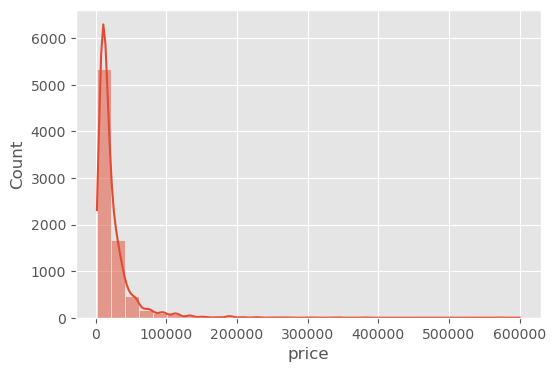

In [7]:
sns.histplot(x='price', data=data, bins=30, kde=True);

In [21]:
data['price'].describe()

count      7948.000000
mean      23899.289129
std       30091.790185
min        2000.000000
25%        9900.000000
50%       15000.000000
75%       27000.000000
max      600000.000000
Name: price, dtype: float64

In [92]:
data[data.price > np.percentile(data.price, 99.9)]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
330,10458331,570000,5,5,"Ломаківська вул. (Мічуріна), 56/2",Печерський р-н,no,ПРЕМІУМ,Пам'ятник засновникам Києва,Добро пожаловать в роскошные апартаменты в клу...,...,0,1,1,0,1,1,1,1,0,0
2739,10807023,380000,6,15,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський р-н,Дніпро,БЕЗ КОМІСІЇ,Печерськ,Опис\nЭксклюзивные апартаменты в ЖК «Diamond H...,...,0,0,0,0,0,0,0,0,0,0
4301,10640634,570000,2,5,"Болсуновський пров. (Мічуріна), 35",Печерський р-н,no,БЕЗ КОМІСІЇ,Пам'ятник засновникам Києва,Такого Вы не видели. Обращайтесь) [ссылка скрыта],...,0,0,0,0,0,0,0,0,0,0
4413,10657968,380000,6,8,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський р-н,Дніпро,БЕЗ КОМІСІЇ,ЖК Diamond Hill,Видовые апартаменты представительского класса ...,...,0,0,0,0,0,0,0,0,0,0
5882,10830459,380000,5,9,"Драгомирова вул., 11Б",Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,Предлагаются в аренду Новые дизайнерские 5-ком...,...,1,0,1,1,1,1,0,1,1,0
7062,10830532,518000,4,20,"Драгомирова вул., 20",Печерський р-н,Дружби народів,Дружби народів,ЖК Новопечерські Липки,Аренда 4-комнатной квартиры в жилом комплексе ...,...,0,0,1,0,1,1,0,1,0,0
7802,10820150,600000,3,9,"Арсенальна пл., 8",Печерський р-н,Арсенальна,Арсенальна,Маріїнський парк,Тут ви можете дати волю фантазії і описати об’...,...,0,0,0,0,0,0,0,0,0,0


It's very skewed data, so let's use logarithm.

In [9]:
data['price_log'] = np.log1p(data['price'])

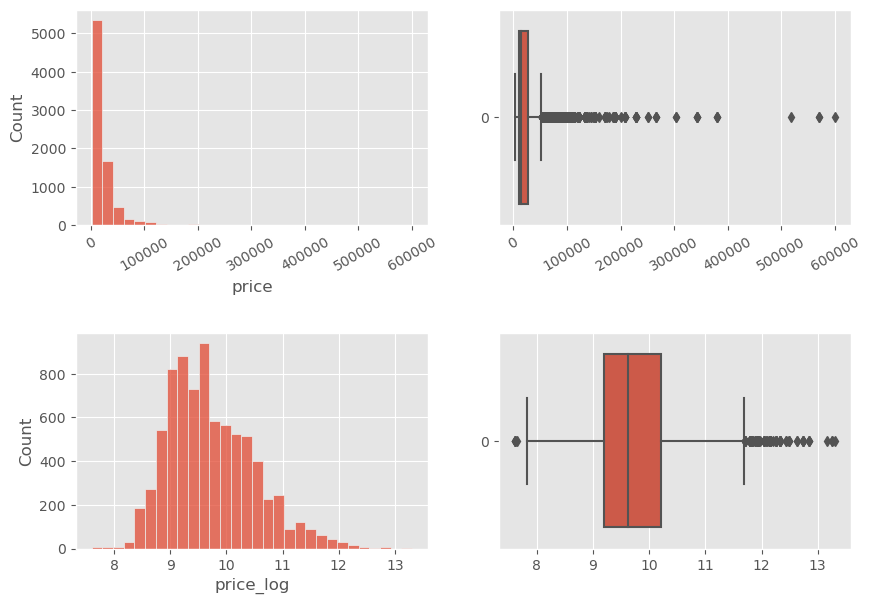

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.subplots_adjust(hspace=.5)

sns.histplot(data['price'], ax=ax[0, 0], bins=30)
sns.boxplot(data['price'], ax=ax[0, 1], orient='h')
ax[0][0].tick_params('x', labelrotation=30)
ax[0][1].tick_params('x', labelrotation=30)

sns.histplot(data['price_log'], ax=ax[1, 0], bins=30)
sns.boxplot(data['price_log'], ax=ax[1, 1], orient='h')

plt.show()

### Features types

In [97]:
data.columns

Index(['id', 'price', 'rooms', 'floor', 'adress', 'district', 'subway',
       'class', 'residential', 'description', 'detail', 'full_area',
       'living_area', 'kitchen_area', 'num_storeys', 'subway_old',
       'typical_panel', 'concrete_monolithic', 'old_brick', 'first_rental',
       'adjacent_separate', 'ukrainian_brick', 'eurorenovation',
       'satisfactory_condition', 'multilevel', 'needs_cosmetic_repairs',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'needs_major_repairs', 'gas_block',
       'repair_in_progress', 'free_planning', 'adjacent', 'separate',
       'ukrainian_panel', 'Stalinka', 'excellent_condition', 'studio',
       'designer_renovation', 'safe', 'shower_cabin', 'wardrobe', 'TV',
       'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player', 'washing_machine',
       'fireplace', 'dishwashers', 'alarms', 'bed', 'counters',
       'air_conditioning', 'refrigerator', 'jacuzzi', 'microwave', 'iron',
       '

In [44]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']

In [45]:
feats = [col for col in data.columns if col not in black_list]

In [102]:
feats

['rooms',
 'floor',
 'adress',
 'district',
 'subway',
 'full_area',
 'living_area',
 'kitchen_area',
 'num_storeys',
 'typical_panel',
 'concrete_monolithic',
 'old_brick',
 'first_rental',
 'adjacent_separate',
 'ukrainian_brick',
 'eurorenovation',
 'satisfactory_condition',
 'multilevel',
 'needs_cosmetic_repairs',
 'kitchen_living_room',
 'penthouse',
 'old_panel',
 'good_condition',
 'pre_revolutionary',
 'needs_major_repairs',
 'gas_block',
 'repair_in_progress',
 'free_planning',
 'adjacent',
 'separate',
 'ukrainian_panel',
 'Stalinka',
 'excellent_condition',
 'studio',
 'designer_renovation',
 'safe',
 'shower_cabin',
 'wardrobe',
 'TV',
 'hair_dryer',
 'dishes',
 'satellite_TV',
 'DVD_player',
 'washing_machine',
 'fireplace',
 'dishwashers',
 'alarms',
 'bed',
 'counters',
 'air_conditioning',
 'refrigerator',
 'jacuzzi',
 'microwave',
 'iron',
 'cable_TV']

In [46]:
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
cat_feats

['rooms', 'adress', 'district', 'subway']

In [47]:
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]
print(len(num_feats))

51


In [9]:
for feat in cat_feats:
    print(f"{feat}: {data[feat].nunique()} unique values")

rooms: 7 unique values
adress: 3997 unique values
district: 11 unique values
subway: 52 unique values


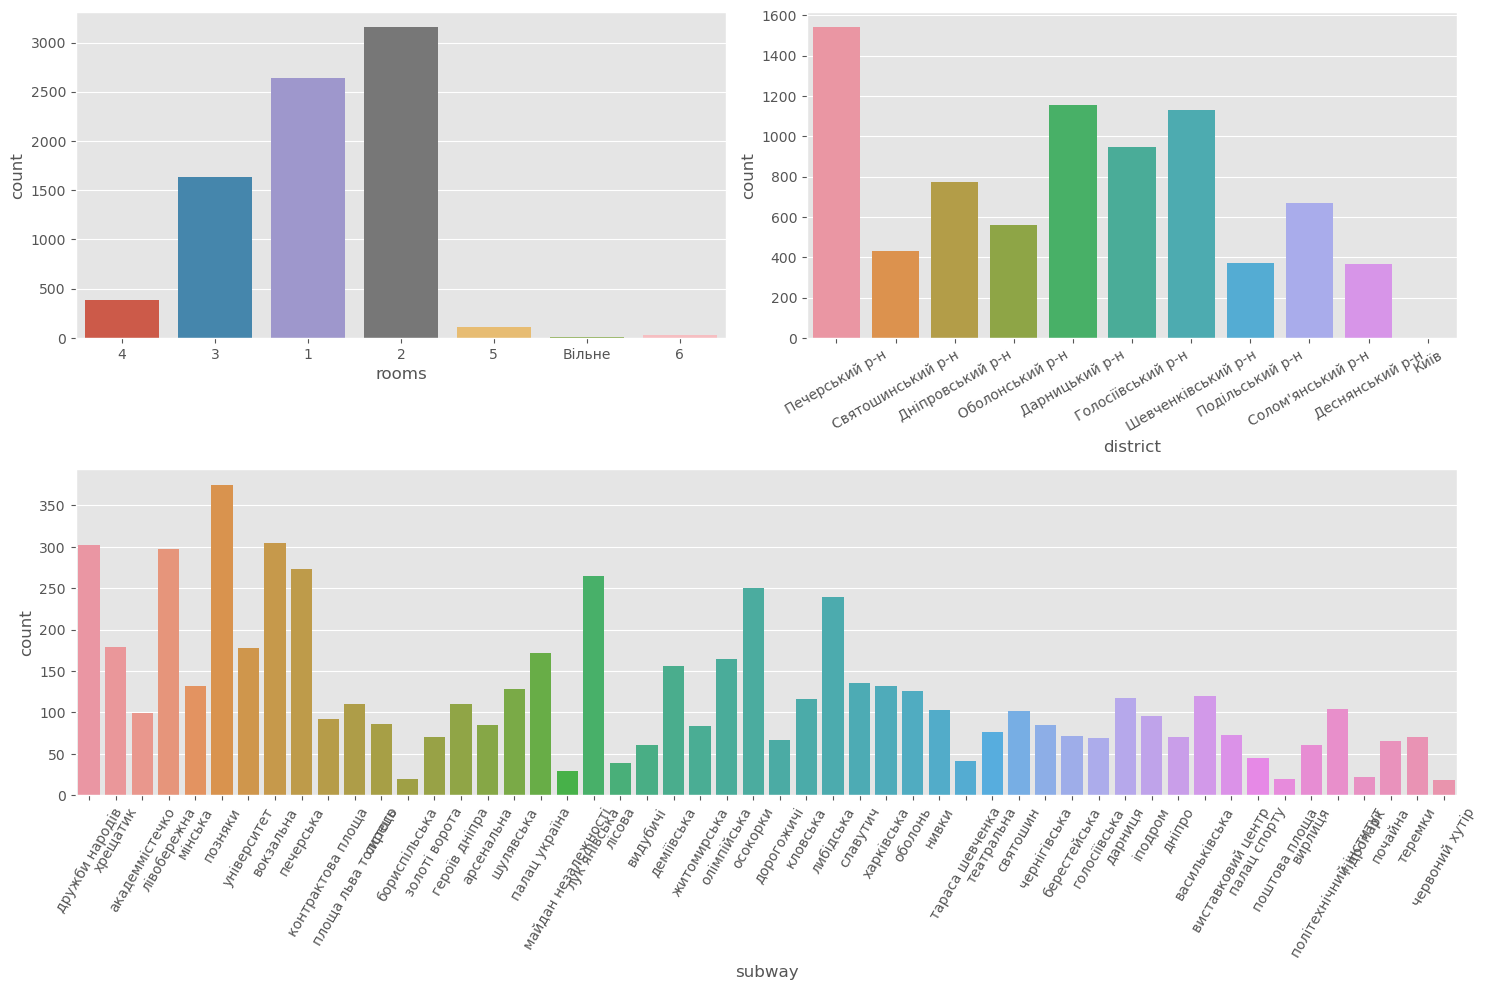

In [201]:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(221)
sns.countplot(x='rooms', data=data, ax=ax1)

ax2 = plt.subplot(222)
sns.countplot(x='district', data=data, ax=ax2)
ax2.tick_params('x', labelrotation=30)

ax3 = plt.subplot(212)
sns.countplot(x='subway', data=data, ax=ax3)
ax3.tick_params('x', labelrotation=60)

plt.tight_layout()
plt.show()

**Categorial Features vs Price**

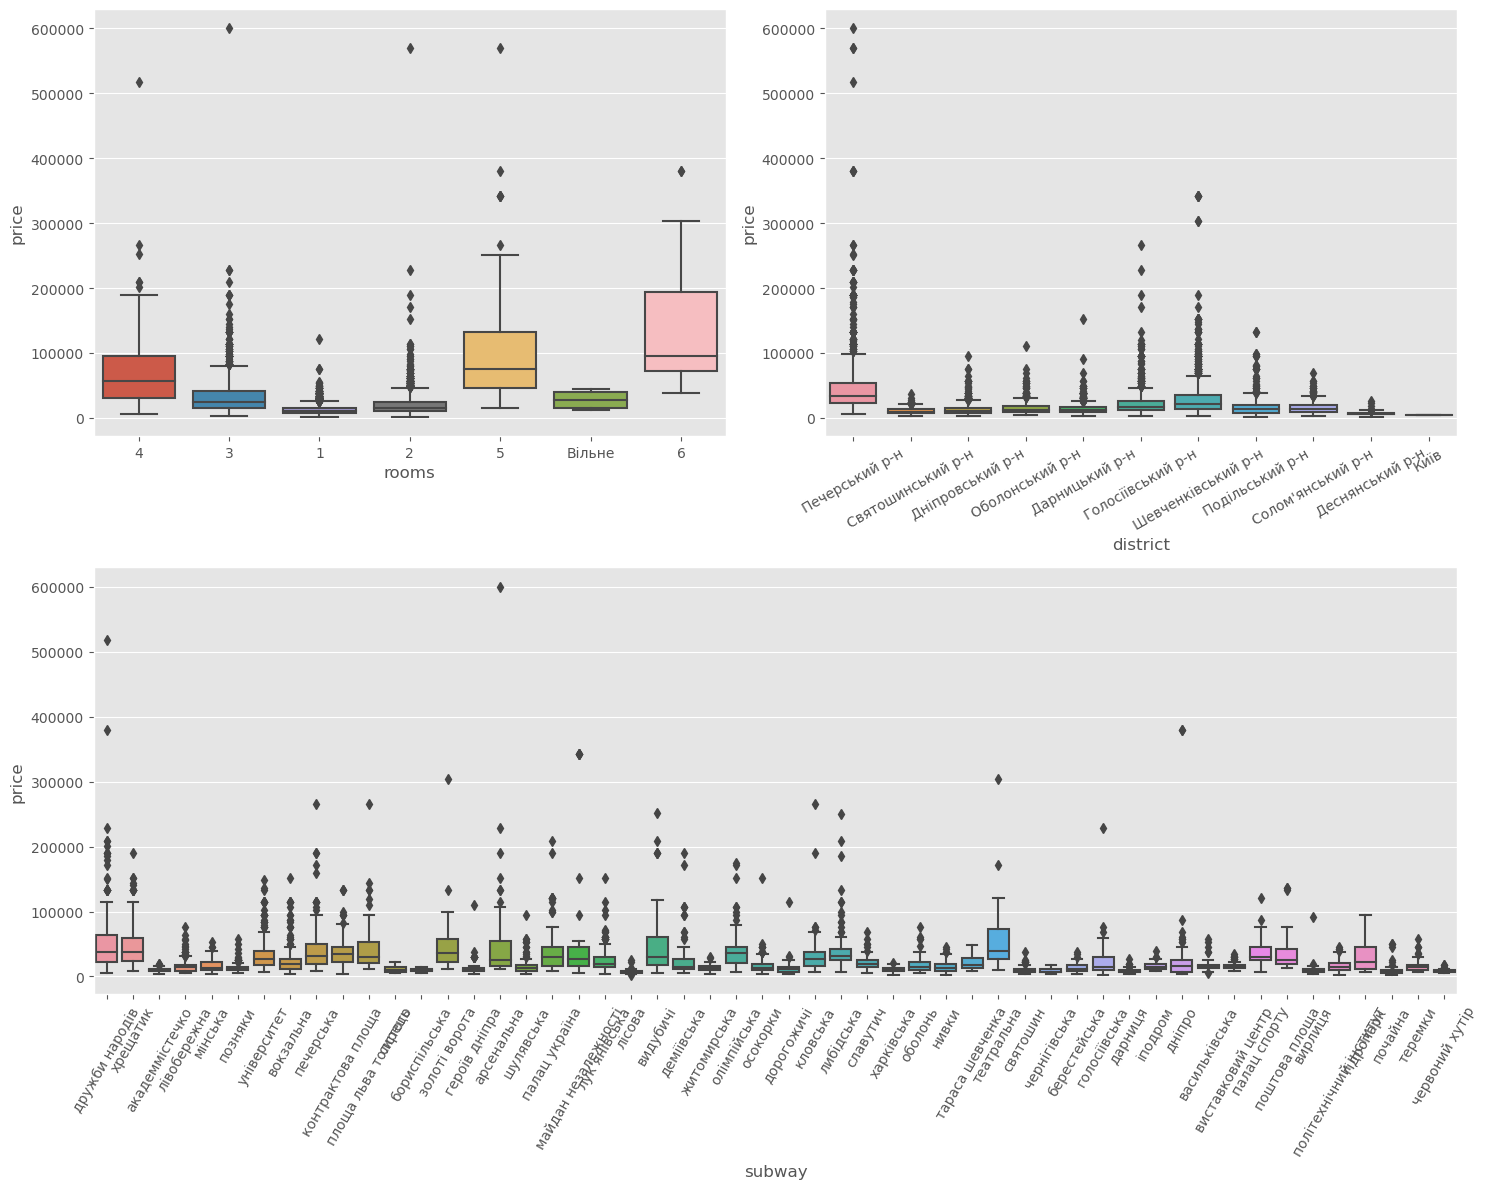

In [200]:
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(221)
sns.boxplot(x='rooms', y='price', data=data, ax=ax1)

ax2 = plt.subplot(222)
sns.boxplot(x='district', y='price', data=data, ax=ax2)
ax2.tick_params('x', labelrotation=30)

ax3 = plt.subplot(212)
sns.boxplot(x='subway', y='price', data=data, ax=ax3)
ax3.tick_params('x', labelrotation=60)

plt.tight_layout()
plt.show()

**Analize Numerical (Continuous) Features**

In [17]:
items = []

for feat in num_feats:
    items.append({
        "name": feat,
        "count": data[feat].nunique()
    })

pd.DataFrame(items).sort_values("count", ascending=False)

,name,count
1,full_area,349
2,living_area,244
3,kitchen_area,157
4,num_storeys,45
0,floor,36
39,washing_machine,2
30,designer_renovation,2
31,safe,2
32,shower_cabin,2
33,wardrobe,2


Continious features: `full_area`, `living_area`, `kitchen_area`, `num_storeys`, `floor`.
Other numeric features is boolean (1, 0).

In [18]:
countinious_feats = ['full_area', 'living_area', 'kitchen_area', 'num_storeys', 'floor']

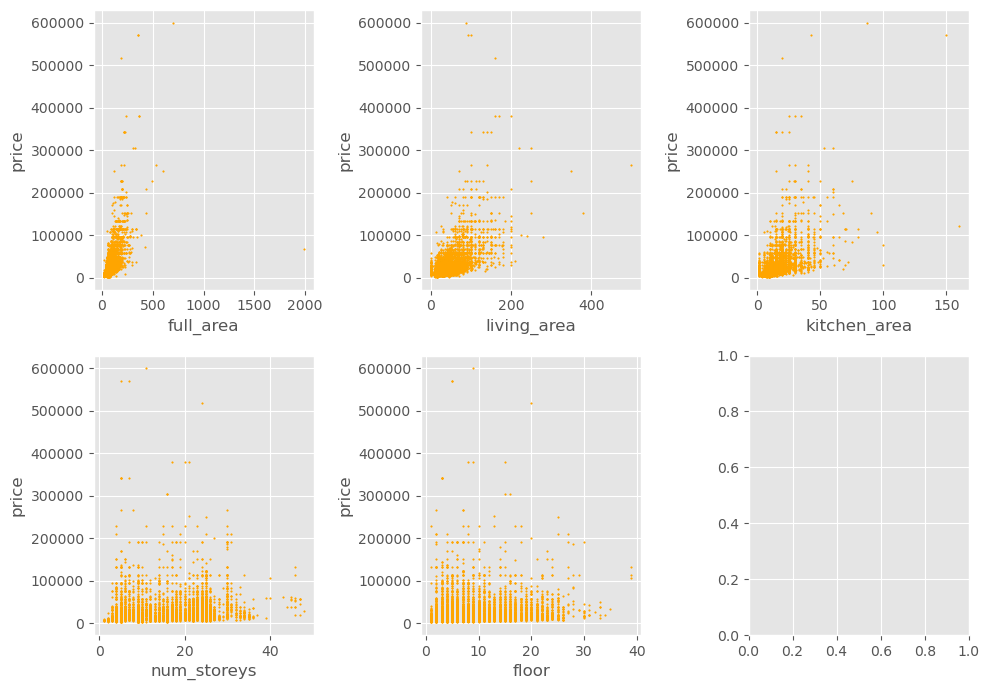

In [25]:
f,ax = plt.subplots(2, 3, figsize=(10, 7))
k=0
for i in range(2):
    for j in range(3):
        if k<5:
            ax[i][j].scatter(x=countinious_feats[k], y='price', data=data, s=1, color='orange')
            ax[i][j].set_xlabel(countinious_feats[k])
            ax[i][j].set_ylabel('price')
            k += 1

plt.tight_layout()
plt.show()

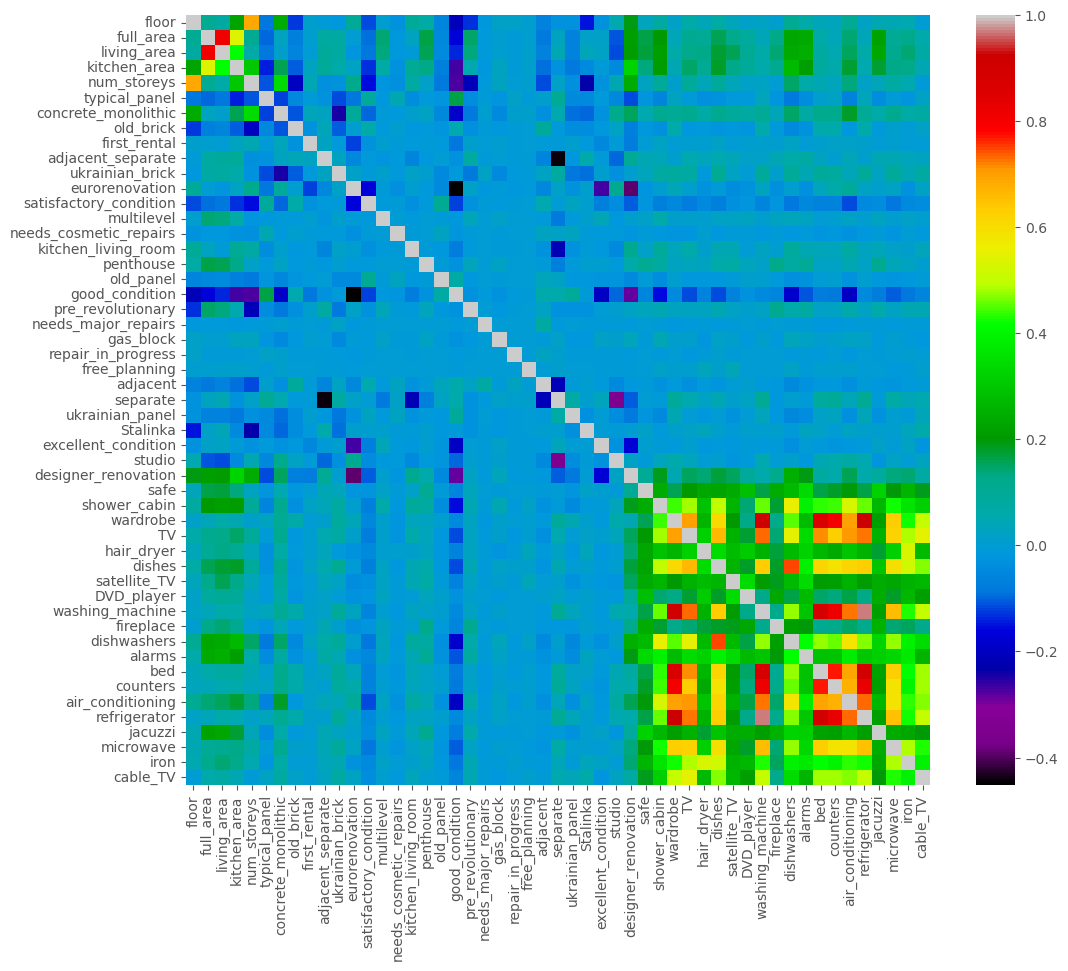

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[num_feats].corr(), cmap='nipy_spectral')
plt.show()

Plotting the first 12 correlations with `price`

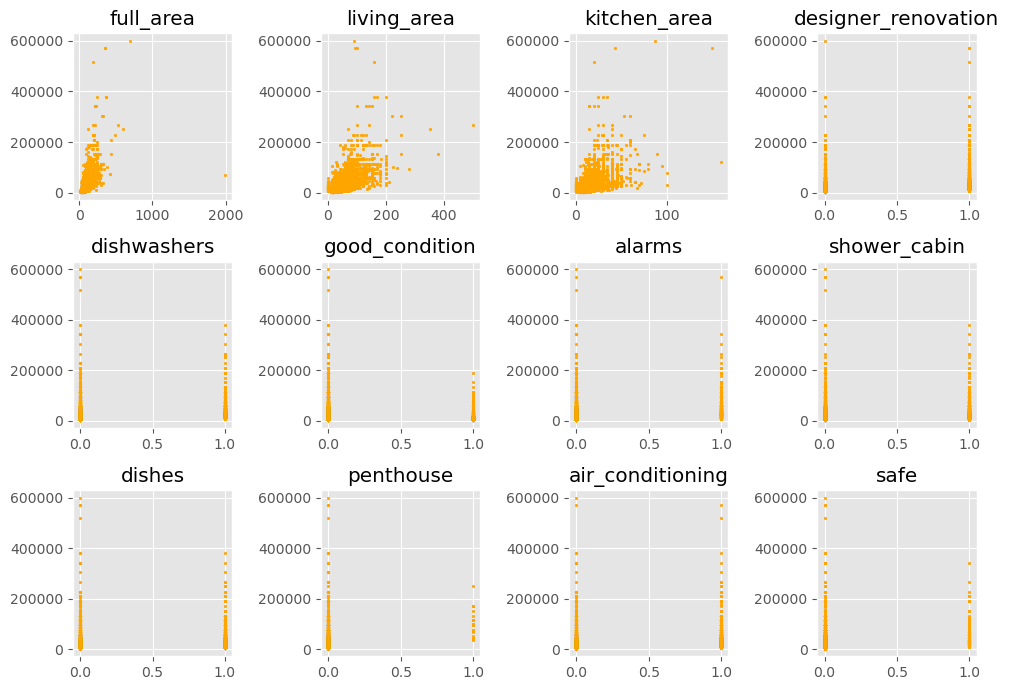

In [45]:
plt.figure(figsize=(10, 7))
keys = data[num_feats+['price']].corr()["price"].abs().sort_values(ascending=False)[1:13].index
for i, key in enumerate(keys):
    plt.subplot(3, 4, i+1)
    plt.scatter(data[key], data["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

Plotting the first 12 correlations with `price_log`

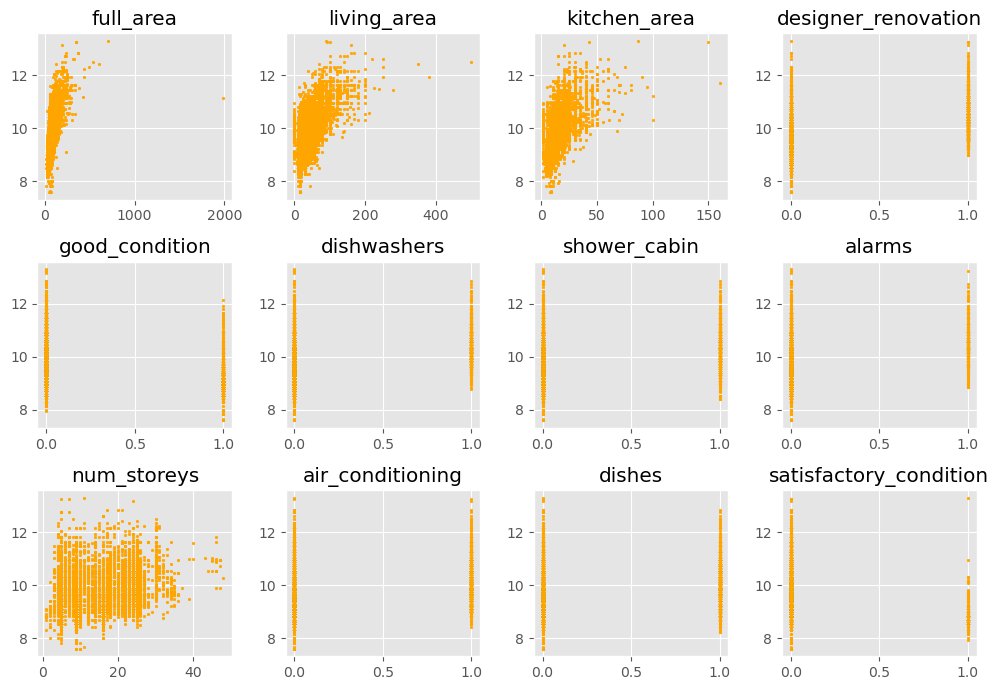

In [44]:
plt.figure(figsize=(10, 7))
keys = data[num_feats+['price_log']].corr()['price_log'].abs().sort_values(ascending=False)[1:13].index
for i, key in enumerate(keys):
    plt.subplot(3, 4, i+1)
    plt.scatter(data[key], data['price_log'], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [104]:
nan_values = data[feats].isna().sum()
display(nan_values[nan_values > 0].sort_values(ascending=False))

subway    1636
dtype: int64

### `subway`

In [ ]:
# data['subway'].fillna('no', inplace=True)

Convert 'rooms' column to categorical type.

In [24]:
data['rooms'] = data['rooms'].astype('category')
data['rooms']

0       4
1       3
2       3
3       1
4       1
       ..
7943    1
7944    1
7945    2
7946    1
7947    2
Name: rooms, Length: 7948, dtype: category
Categories (7, object): ['1', '2', '3', '4', '5', '6', 'Вільне']

In [54]:
data['district'].value_counts(dropna=False)

Печерський р-н        1540
Дарницький р-н        1154
Шевченківський р-н    1131
Голосіївський р-н      949
Дніпровський р-н       773
Солом'янський р-н      669
Оболонський р-н        561
Святошинський р-н      432
Подільський р-н        372
Деснянський р-н        366
Київ                     1
Name: district, dtype: int64

### `adress`

In [49]:
data['adress']

0                             Драгомирова вул., 11
1                                  Шовковична вул.
2                                 Лютеранська вул.
3                                   Доковська вул.
4                                   Каховська вул.
                           ...                    
7943                      Крамського Івана вул., 9
7944                 Кіпріанова академіка вул., 6А
7945    Данила Щербаківського вул. (Щербакова), 54
7946                        Стуса Василя вул., 28а
7947                         Гродненська вул., 3/5
Name: adress, Length: 7948, dtype: object

!!! **Try to use direct geocoding (geopy) to extract (lat,long) pairs from adress**

## Baseline

metric: RMSLE 

cross_validation: KFold

In [3]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [12]:
train, test = train_test_split(data, test_size=0.2, random_state=24)
print(train.shape, test.shape)

(6358, 63) (1590, 63)


In [ ]:
train.to_csv('real_estate_train.csv', index=False)
test.to_csv('real_estate_test.csv', index=False)

In [50]:
train = pd.read_csv('real_estate_train.csv')
test = pd.read_csv('real_estate_test.csv')

In [191]:
# get X_train, X_test, y_train, y_test from data
def get_train_test(df, feats, log=False):
    X = df[feats]
    if log:
        y = np.log1p(df['price'])
    else:
        y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test

In [5]:
# get X, y from df with specified target
def get_X_y(df, features, target):
    X = df[features]
    y = df[target]
    return X, y

### First attempt for RMSLE and cv

*Create Stratified KFold for continious target (Continuous Target Stratification)*
https://www.kaggle.com/code/tolgadincer/continuous-target-stratification/notebook

def create_skfolds(df, target, n_s=3, n_grp=None):
    df['fold'] = -1

    if n_grp is None:
        skf = KFold(n_splits=n_s)
        target = df[target]
    else:
        skf = StratifiedKFold(n_splits=n_s)
        df['grp'] = pd.cut(df[target], n_grp, labels=False)
        target = df.grp

    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'fold'] = fold_no
    return df

In [22]:
#def rmsle_score(y_true, y_pred):
#    return np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

In [9]:
def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)


def rmsle_score_log_target(y_true, y_pred):
    rmsle_score = mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred), squared=False)
    return rmsle_score

In [10]:
rmsle = make_scorer(rmsle_score, greater_is_better=False)
rmsle_log = make_scorer(rmsle_score_log_target, greater_is_better=False)

In [47]:
def cv_rmsle(model, log_target=False):
    if log_target:
        scores = cross_val_score(model, X_train, y_train,
                                 scoring=rmsle_log,
                                 cv=skf, n_jobs=-1)
    else:
        scores = cross_val_score(model, X_train, y_train,
                                 scoring=rmsle,
                                 cv=skf, n_jobs=-1)
    #return scores
    return np.mean(np.sqrt(np.abs(scores)))

#### `price`

In [48]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)
print(X_train. shape, y_train.shape)

(6358, 51) (6358,)


In [49]:
model = DummyRegressor(strategy='mean')

print("RMSLE: ", np.round(cv_rmsle(model), 4))

RMSLE:  0.9203


In [50]:
model = DummyRegressor(strategy='median')

print("RMSLE: ", np.round(cv_rmsle(model), 4))

RMSLE:  0.8804


In [51]:
model = ExtraTreesRegressor(max_depth=7, random_state=24)

print("RMSLE: ", np.round(cv_rmsle(model), 4))

RMSLE:  0.6408


In [114]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

In [131]:
parameters = {
    "n_estimators": 100,
    "max_depth": 5,
    #"max_leaves": 10,
    "grow_policy": "lossguide",
    "learning_rate": 0.1,
    "verbosity": 1,    
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "tree_method": "hist",
    "n_jobs": 4,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "random_state": 24,
}

model = xgb.XGBRegressor(**parameters)

print("RMSLE: ", np.round(cv_rmsle(model, log_target=False), 4))

RMSLE:  0.6187


In [139]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train, y_train)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)

[0]	train-rmsle:2.23656+0.00743	test-rmsle:2.23782+0.01798
[50]	train-rmsle:0.37999+0.00639	test-rmsle:0.40508+0.00826
[100]	train-rmsle:0.35703+0.00691	test-rmsle:0.39352+0.00983
[119]	train-rmsle:0.35214+0.00769	test-rmsle:0.39285+0.00990


#### `price_log`

In [82]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=True)

In [132]:
model = DummyRegressor(strategy='mean')

print("RMSLE: ", np.round(cv_rmsle(model, log_target=True), 4))

RMSLE:  0.8764


In [134]:
model = DummyRegressor(strategy='median')


print("RMSLE: ", np.round(cv_rmsle(model, log_target=True), 4))

RMSLE:  0.8804


In [135]:
model = ExtraTreesRegressor(max_depth=7, random_state=24)

print("RMSLE: ", np.round(cv_rmsle(model, log_target=True), 4))

RMSLE:  0.6226


In [55]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=True)

In [37]:
parameters = {
    "n_estimators": 100,
    "max_depth": 3,
    "max_leaves": 3,
    "grow_policy": "lossguide",
    "learning_rate": 0.1,
    "verbosity": 1,    
    "objective": "reg:squaredlogerror",
    #"eval_metric": "rmsle",
    "tree_method": "hist",
    "n_jobs": 4,
    "eval_metric": "rmsle",
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "random_state": 24,
}

model = xgb.XGBRFRegressor(**parameters)

print("RMSLE: ", np.round(cv_rmsle(model, log_target=True), 4))

RMSLE:  [nan nan nan]


In [100]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=True)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train, y_train)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)

[0]	train-rmse:8.33291+0.00687	test-rmse:8.33272+0.01585
[50]	train-rmse:0.38731+0.00370	test-rmse:0.39604+0.00579
[100]	train-rmse:0.36598+0.00439	test-rmse:0.37846+0.01040
[150]	train-rmse:0.35776+0.00488	test-rmse:0.37328+0.01053
[200]	train-rmse:0.35158+0.00515	test-rmse:0.36938+0.01099
[250]	train-rmse:0.34688+0.00528	test-rmse:0.36700+0.01098
[300]	train-rmse:0.34303+0.00550	test-rmse:0.36536+0.01150
[332]	train-rmse:0.34098+0.00550	test-rmse:0.36471+0.01143


In [27]:
def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
        
        y_pred[y_pred < 0] = 0 #иногда может быть отрицательное значение

        score = mean_squared_log_error(y_test, y_pred, squared=False)
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

In [31]:
X_train, y_train = get_X_y(train, num_feats, 'price')

In [32]:
parameters = {
    "n_estimators": 100,
    "max_depth": 3,
    "max_leaves": 3,
    "grow_policy": "lossguide",
    "learning_rate": 0.1,
    "verbosity": 1,    
    "objective": "reg:squaredlogerror",
    #"eval_metric": "rmsle",
    "tree_method": "hist",
    "n_jobs": 4,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "random_state": 24,
}

model = xgb.XGBRegressor(**parameters)

run_cv(model, X_train, y_train, folds=3, target_log=True, cv_type=KFold)

(0.4106603749440927, 0.005179333262883112)

In [35]:
model = xgb.XGBRegressor(**parameters)

run_cv(model, X_train, y_train, folds=3, target_log=False, cv_type=KFold)

(4.886795219734829, 0.016972952847031913)

In [29]:
model = ExtraTreesRegressor(max_depth=7, random_state=24)

run_cv(model, X_train, y_train, folds=3, target_log=False, cv_type=KFold)

(0.4107699352868055, 0.012003987768551598)

In [162]:
model = ExtraTreesRegressor(max_depth=7, random_state=24)

run_cv(model, X_train, y_train, folds=3, target_log=True, cv_type=KFold)

(0.38755381265122574, 0.009776890365077796)

In [165]:
model = DummyRegressor(strategy='mean')
run_cv(model, X_train, y_train, folds=3, target_log=True, cv_type=KFold)

(0.7680510207170603, 0.009486913805300878)

In [166]:
model = DummyRegressor(strategy='mean')
run_cv(model, X_train, y_train, folds=3, target_log=False, cv_type=KFold)

(0.8470083474345419, 0.0064624552998155)

In [15]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y

X_train, y_train, = get_X_y(data, num_feats)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train, y_train)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)

[0]	train-rmsle:2.20501+0.00460	test-rmsle:2.20916+0.02576
[50]	train-rmsle:0.44145+0.00427	test-rmsle:0.44896+0.00680
[100]	train-rmsle:0.41045+0.00159	test-rmsle:0.42101+0.00483
[150]	train-rmsle:0.39845+0.00044	test-rmsle:0.41118+0.00270
[200]	train-rmsle:0.39160+0.00132	test-rmsle:0.40613+0.00348
[228]	train-rmsle:0.38803+0.00279	test-rmsle:0.40391+0.00183


In [19]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y

X_train, y_train, = get_X_y(data, num_feats)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train, y_train)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)

[0]	train-rmsle:2.20501+0.00460	test-rmsle:2.20916+0.02576
[50]	train-rmsle:0.44145+0.00427	test-rmsle:0.44896+0.00680
[100]	train-rmsle:0.41045+0.00159	test-rmsle:0.42101+0.00483
[150]	train-rmsle:0.39845+0.00044	test-rmsle:0.41118+0.00270
[200]	train-rmsle:0.39160+0.00132	test-rmsle:0.40613+0.00348
[227]	train-rmsle:0.38830+0.00272	test-rmsle:0.40416+0.00167


### Second attemp!!

In [10]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y

def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
        
        y_pred[y_pred < 0] = 0

        score = rmsle(y_test, y_pred)
        scores.append(score)
        
    print(f"RMSLE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")     
    return

In [25]:
X_train, y_train = get_X_y(train, num_feats)
model = xgb.XGBRegressor()
run_cv(model, X_train, y_train, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle)

RMSLE: 0.3969 ± 0.0124


In [26]:
run_cv(model, X_train, y_train, folds=3, target_log=True, cv_type=KFold, success_metric=rmsle)

RMSLE: 0.3693 ± 0.0146


### TransformedTargetRegressor

In [53]:
from sklearn.compose import TransformedTargetRegressor

In [143]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

In [144]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_squared_log_error(y_test, y_pred, squared=False)

0.3586416654872728

In [148]:
model_log = TransformedTargetRegressor(
    regressor=xgb.XGBRegressor(),
    func=np.log, inverse_func=np.exp
)

model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

mean_squared_log_error(y_test, y_pred, squared=False)


0.34171958230583604

In [159]:
model_log = TransformedTargetRegressor(
    regressor=xgb.XGBRegressor(),
    func=np.log, inverse_func=np.exp
)
scores = cross_val_score(model_log, X_train, y_train,
                scoring=rmsle,
                cv=skf, n_jobs=-1)

array([-0.35004905, -0.38539697, -0.37258435])

### Third attempt (train and val score)

In [4]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y

In [7]:
X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

In [5]:
def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

In [6]:
def calc_train_error(X_train, y_train, model, metric, target_log):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_train = np.exp(y_train)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_train, y_pred][:5])
    return metric(y_train, y_pred)
    
def calc_validation_error(X_test, y_test, model, metric, target_log):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    if target_log:
        y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_test, y_pred][:5])
    return metric(y_test, y_pred)
    
def calc_metrics(X_train, y_train, X_test, y_test, model, metric, target_log):
    '''fits model and returns the RMSLE for in-sample error and out-of-sample error'''
    if target_log:
       y_train = np.log(y_train)
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model, metric, target_log)
    validation_error = calc_validation_error(X_test, y_test, model, metric, target_log)
    return train_error, validation_error

In [27]:

def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    train_scores = []
    test_scores = []
    k = 0
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
       
        train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test, model, success_metric, target_log)
        print(f"[Fold {k}] train_rmsle: {train_score:.4f}, test_rmsle: {test_score:.4f}")
        train_scores.append(train_score)
        test_scores.append(test_score)
        k += 1
        
    print(f"RMSLE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    return

In [89]:
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X_train, y_train, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.4201, test_rmsle: 0.4075
[Fold 1] train_rmsle: 0.4084, test_rmsle: 0.4412
[Fold 2] train_rmsle: 0.4132, test_rmsle: 0.4322
RMSLE: 0.4270 ± 0.0142


In [87]:
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X_train, y_train, folds=3, target_log=True, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3733, test_rmsle: 0.3637
[Fold 1] train_rmsle: 0.3623, test_rmsle: 0.3862
[Fold 2] train_rmsle: 0.3649, test_rmsle: 0.3857
RMSLE: 0.3786 ± 0.0105


## Geoencoding

In [2]:
data = pd.read_csv('real_estate_clean_drop_duplicate.csv')

In [9]:
geolocator = Nominatim(user_agent="my_request")

In [18]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [ ]:
# to see a progress bar
from tqdm import tqdm
tqdm.pandas()

In [41]:
data['adress'].apply(lambda x: x + ', Київ')

0                             Драгомирова вул., 11, Київ
1                                  Шовковична вул., Київ
2                                   Доковська вул., Київ
3                                   Каховська вул., Київ
4                           Оболонський просп., 26, Київ
                              ...                       
6933                      Крамського Івана вул., 9, Київ
6934                 Кіпріанова академіка вул., 6А, Київ
6935    Данила Щербаківського вул. (Щербакова), 54, Київ
6936                        Стуса Василя вул., 28а, Київ
6937                         Гродненська вул., 3/5, Київ
Name: adress, Length: 6938, dtype: object

In [42]:
data['location'] = data['adress'].apply(lambda x: x + ', Київ').progress_apply(geocode)

100%|██████████| 6938/6938 [1:56:16<00:00,  1.01s/it]


In [32]:
data['location']

0       (11, вулиця Михайла Драгомирова, Новопечерські...
1       (Шовковична вулиця, Shatilovka Hillside, Сокол...
2       (Гапонів доківська, Залізнична вулиця, Коцюбин...
3       (Каховська вулиця, Чернівці, Чернівецька міськ...
4       (СУШИ-МАСТЕР, 26, Оболонський проспект, Оболон...
                              ...                        
6933    (Бутік Отік, 9, вулиця Івана Крамського, Скарб...
6934    (6-А, Академіка Кіпріанова вулиця, Микільська ...
6935    (Ощадбанк, 54, вулиця Данила Щербаківського, Н...
6936    (Василя Стуса вулиця, Макарів, Макарівська сел...
6937    (3/5, Гродненська вулиця, Ліски, Дніпровський ...
Name: location, Length: 6938, dtype: object

In [43]:

data['lat'] = data['location'].apply(lambda x: x.latitude if x else None)
data['lon'] = data['location'].apply(lambda x: x.longitude if x else None)


In [44]:
data[['adress', 'location', 'lat', 'lon']]

,adress,location,lat,lon
0,"Драгомирова вул., 11","(11, вулиця Михайла Драгомирова, Новопечерські...",50.409315,30.545859
1,Шовковична вул.,"(Шовковична вулиця, Левашовська Гора, Графська...",50.440876,30.527947
2,Доковська вул.,"(Гапонів доківська, Залізнична вулиця, Коцюбин...",50.488823,30.334814
3,Каховська вул.,"(Каховська вулиця, Микільська Слобідка, Дніпро...",50.468776,30.585959
4,"Оболонський просп., 26","(СУШИ-МАСТЕР, 26, Оболонський проспект, Оболон...",50.513615,30.499695
...,...,...,...,...
6933,"Крамського Івана вул., 9","(Бутік Отік, 9, вулиця Івана Крамського, Скарб...",50.453460,30.372720
6934,"Кіпріанова академіка вул., 6А","(6-А, Академіка Кіпріанова вулиця, Микільська ...",50.438831,30.379677
6935,"Данила Щербаківського вул. (Щербакова), 54","(Ощадбанк, 54, вулиця Данила Щербаківського, Н...",50.471670,30.406559
6936,"Стуса Василя вул., 28а","(Василя Стуса вулиця, Макарів, Макарівська сел...",50.472214,29.826320


In [50]:
data[data['lat'] == data['lat'].max()]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon
955,10821569,8000,1,8,"Героїв Дніпра вул., 71",Оболонський р-н,героїв дніпра,Героїв Дніпра,Оболонь,Здається в оренду простора 1кімнатна квартира ...,...,1,0,1,0,1,0,0,"(Героїв Дніпра вулиця, Славутич, Славутицька м...",51.524015,30.7651
6336,10830158,12000,2,6,"Героїв Дніпра вул., 71",Оболонський р-н,героїв дніпра,Героїв Дніпра,Оболонь,"Здам 2 кімнатну квартиру, метро Героїв Дніпра,...",...,0,0,0,0,0,0,0,"(Героїв Дніпра вулиця, Славутич, Славутицька м...",51.524015,30.7651


In [51]:
data.loc[955, 'lat'] = 50.5229136
data.loc[955, 'lon']= 30.5109433
data.loc[6336, 'lat'] = 50.5229136
data.loc[6336, 'lon']= 30.5109433

In [74]:
subway_stations = {
    'академмістечко', 'арсенальна', 'берестейська', 'бориспільська', 
    'васильківська', 'видубичі', 'вирлиця', 'виставковий центр', 
    'вокзальна', 'героїв дніпра', 'гідропарк', 'голосіївська', 
    'дарниця', 'деміївська', 'дніпро', 'дорогожичі', 'дружби народів', 
    'житомирська', 'золоті ворота', 'іподром', 'кловська', 
    'контрактова площа', 'либідська', 'лівобережна', 'лісова', 
    'лук\'янівська', 'майдан незалежності', 'мінська', 'нивки', 
    'оболонь', 'олімпійська', 'осокорки', 'палац україна', 'палац спорту', 
    'печерська', 'площа льва толстого', 'позняки', 'політехнічний інститут', 
    'почайна', 'поштова площа', 'святошин', 'сирець', 'славутич', 
    'тараса шевченка', 'театральна', 'теремки', 'університет', 'харківська', 
    'хрещатик', 'червоний хутір', 'чернігівська', 'шулявська',
}

In [91]:
loc = 'Київ, станція метро Вирлиця'
geolocator.geocode(loc)

In [75]:
from time import sleep
from tqdm import tqdm

In [76]:
subway_location = {}
for station in tqdm(subway_stations):
    loc = 'метро ' + station + ', Київ'
    location = geolocator.geocode(loc)
    if location:
        subway_lat = location.latitude
        subway_lon = location.longitude
    else:
        subway_lat = None
        subway_lon = None
    subway_location[station] = {'subway_lat': subway_lat, 'subway_lon': subway_lon}
    sleep(1)

100%|██████████| 52/52 [00:57<00:00,  1.11s/it]


In [138]:
df_subway_location = pd.DataFrame(subway_location).T
df_subway_location

,subway_lat,subway_lon
деміївська,50.404655,30.516361
іподром,50.375646,30.466451
вирлиця,None,None
дарниця,50.455608,30.613805
героїв дніпра,50.523104,30.4967
печерська,None,None
либідська,None,None
кловська,50.437083,30.532243
поштова площа,None,None
теремки,50.378757,30.44198


In [139]:
df_subway_location.loc['вирлиця', 'subway_lat'] = 50.4030762
df_subway_location.loc['вирлиця', 'subway_lon'] = 30.6636527
df_subway_location.loc['печерська', 'subway_lat'] = 50.4272737
df_subway_location.loc['печерська', 'subway_lon'] = 30.5368177
df_subway_location.loc['либідська', 'subway_lat'] = 50.412432
df_subway_location.loc['либідська', 'subway_lon'] = 30.5226498
df_subway_location.loc['поштова площа', 'subway_lat'] = 50.458958
df_subway_location.loc['поштова площа', 'subway_lon'] = 30.5224687
df_subway_location.loc['харківська', 'subway_lat'] = 50.401911
df_subway_location.loc['харківська', 'subway_lon'] = 30.6503742
df_subway_location.loc['нивки', 'subway_lat'] = 50.4586495
df_subway_location.loc['нивки', 'subway_lon'] = 30.4017927
df_subway_location.loc['славутич', 'subway_lat'] = 50.3942606
df_subway_location.loc['славутич', 'subway_lon'] = 30.6022841
df_subway_location.loc['майдан незалежності', 'subway_lat'] = 50.4494298
df_subway_location.loc['майдан незалежності', 'subway_lon'] = 30.5212204
df_subway_location.loc['дружби народів', 'subway_lat'] = 50.4173155
df_subway_location.loc['дружби народів', 'subway_lon'] = 30.5444434
df_subway_location.loc['палац спорту', 'subway_lat'] = 50.439721
df_subway_location.loc['палац спорту', 'subway_lon'] = 30.5149799
df_subway_location.loc['васильківська', 'subway_lat'] = 50.3931987
df_subway_location.loc['васильківська', 'subway_lon'] = 30.4848747
df_subway_location.loc['виставковий центр', 'subway_lat'] = 50.3816933
df_subway_location.loc['виставковий центр', 'subway_lon'] = 30.4743447
df_subway_location.loc['площа льва толстого', 'subway_lat'] = 50.4401898
df_subway_location.loc['площа льва толстого', 'subway_lon'] = 30.5157997
df_subway_location.loc['олімпійська', 'subway_lat'] = 50.4317566
df_subway_location.loc['олімпійська', 'subway_lon'] = 30.51393
df_subway_location.loc['берестейська', 'subway_lat'] = 50.4593178
df_subway_location.loc['берестейська', 'subway_lon'] = 30.4141302
df_subway_location.loc['бориспільська', 'subway_lat'] = 50.403877
df_subway_location.loc['бориспільська', 'subway_lon'] = 30.6815092
df_subway_location.loc['палац україна', 'subway_lat'] = 50.4214131
df_subway_location.loc['палац україна', 'subway_lon'] = 30.5181834
df_subway_location.loc['позняки', 'subway_lat'] = 50.3989625
df_subway_location.loc['позняки', 'subway_lon'] = 30.6310943
df_subway_location.loc['політехнічний інститут', 'subway_lat'] = 50.4511297
df_subway_location.loc['політехнічний інститут', 'subway_lon'] = 30.4617132
df_subway_location.loc['видубичі', 'subway_lat'] = 50.401822
df_subway_location.loc['видубичі', 'subway_lon'] = 30.5579077
df_subway_location.loc['гідропарк', 'subway_lat'] = 50.445978
df_subway_location.loc['гідропарк', 'subway_lon'] = 30.5743037
df_subway_location.loc['золоті ворота', 'subway_lat'] = 50.445809
df_subway_location.loc['золоті ворота', 'subway_lon'] = 30.5125747

In [140]:
df_subway_location.reset_index(inplace=True)
df_subway_location.rename(columns={'index': 'subway'}, inplace=True)
df_subway_location

,subway,subway_lat,subway_lon
0,деміївська,50.404655,30.516361
1,іподром,50.375646,30.466451
2,вирлиця,50.403076,30.663653
3,дарниця,50.455608,30.613805
4,героїв дніпра,50.523104,30.4967
5,печерська,50.427274,30.536818
6,либідська,50.412432,30.52265
7,кловська,50.437083,30.532243
8,поштова площа,50.458958,30.522469
9,теремки,50.378757,30.44198


In [185]:
df_subway_location.to_csv('subway_location.csv', index=False)

In [141]:
data.merge(df_subway_location, how='left', on='subway')

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,subway_lat,subway_lon
0,10825753,133000,4,14,"Драгомирова вул., 11",Печерський р-н,дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",...,1,0,1,1,0,"(11, вулиця Михайла Драгомирова, Новопечерські...",50.409315,30.545859,50.417316,30.544443
1,10784117,22762,3,6,Шовковична вул.,Печерський р-н,хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,...,1,0,0,1,1,"(Шовковична вулиця, Левашовська Гора, Графська...",50.440876,30.527947,50.44712,30.522115
2,10810186,8499,1,19,Доковська вул.,Святошинський р-н,академмістечко,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,...,0,0,0,0,0,"(Гапонів доківська, Залізнична вулиця, Коцюбин...",50.488823,30.334814,50.4647,30.353088
3,10824293,10500,1,18,Каховська вул.,Дніпровський р-н,лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,...,0,0,0,0,0,"(Каховська вулиця, Микільська Слобідка, Дніпро...",50.468776,30.585959,50.452886,30.601301
4,10819688,37962,2,18,"Оболонський просп., 26",Оболонський р-н,мінська,ПРЕМІУМ,ЖК Obolon Residences,"ВИДЕО-ТУР\n\nНОВАЯ 2-к квартира, ЖК Obolon Res...",...,1,0,1,0,0,"(СУШИ-МАСТЕР, 26, Оболонський проспект, Оболон...",50.513615,30.499695,50.511618,30.493042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933,10620878,16000,1,9,"Крамського Івана вул., 9",Святошинський р-н,житомирська,Доступна на короткий термін,"ЖК Будинок на вул. Крамського, 9","м. Київ, вул. Крамського 9. Оренда 1но кім. ...",...,1,0,0,1,1,"(Бутік Отік, 9, вулиця Івана Крамського, Скарб...",50.453460,30.372720,50.456063,30.365422
6934,10803998,9500,1,8,"Кіпріанова академіка вул., 6А",Святошинський р-н,святошин,NaN,Микільська Борщагівка,Здам 1-кімнатну квартиру по вул. Академіка Кіп...,...,1,0,0,1,0,"(6-А, Академіка Кіпріанова вулиця, Микільська ...",50.438831,30.379677,50.458009,30.393065
6935,9615917,6000,2,3,"Данила Щербаківського вул. (Щербакова), 54",Шевченківський р-н,святошин,Святошин,Нивки,На длительную аренду по ул Львовская в отличн...,...,1,0,0,0,0,"(Ощадбанк, 54, вулиця Данила Щербаківського, Н...",50.471670,30.406559,50.458009,30.393065
6936,10055853,9000,1,3,"Стуса Василя вул., 28а",Святошинський р-н,NaN,NaN,NaN,"Просторная квартира, большая кухня, два балкон...",...,1,0,1,1,0,"(Василя Стуса вулиця, Макарів, Макарівська сел...",50.472214,29.826320,NaN,NaN


In [114]:
from geopy.distance import geodesic

adr = (50.471670, 30.406559)
metro = (50.458009, 30.393065)

print(geodesic(adr, metro).kilometers)
print(distance(adr, metro).kilometers)

1.7964444182662869
1.7964444182662869


In [157]:
for row in data.index:
    if data.loc[row, 'location']:
        print((data.loc[row, 'location'].latitude, data.loc[row, 'location'].longitude))

(50.4093151, 30.545859115761196)
(50.4408764, 30.5279472)
(50.4888231, 30.3348139)
(50.4687757, 30.585959)
(50.5136152, 30.499695)
(50.4429445, 30.5284137)
(50.4097148, 30.3852201)
(50.4593452, 30.510287599747475)
(50.4477875, 30.5903154)
(50.47095, 30.3566574)
(50.4790478, 30.4370189)
(50.4126722, 30.5469048913234)
(50.4088354, 30.544936488202143)
(50.4065984, 30.674586724144735)
(50.5172157, 30.495914354608907)
(50.4397578, 30.517301)
(50.43856425, 30.539254859861337)
(50.5216492, 30.48725589059034)
(49.7996159, 30.1143681)
(50.42047115, 30.53046739953556)
(50.4650696, 30.44006)
(50.4512372, 30.5220381)
(50.4499125, 30.5156569)
(50.4456702, 30.527533)
(50.475983, 30.670437015462426)
(50.4233169, 30.5383551)
(50.4180003, 30.5409558)
(50.4092871, 30.5440949)
(50.4098705, 30.5465844)
(50.40727925, 30.555634993229162)
(50.407485, 30.5097445)
(50.3975129, 30.5283746)
(50.4070658, 30.5439903)
(50.3928639, 30.6436395)
(50.4276974, 30.546676150185757)
(50.43944595000001, 30.518184223462583)


In [152]:
adr = (50.471670, 30.406559)
list_dist = []
for station in subway_stations:
    
    idx = df_subway_location.index[df_subway_location['subway'] == station]
    subway_loc = (float(df_subway_location.loc[idx, 'subway_lat']), float(df_subway_location.loc[idx, 'subway_lon']))
    list_dist.append(geodesic(adr, subway_loc).kilometers)
print(min(list_dist))

1.4754473907815546


In [163]:
def get_min_dist_to_subway(x):
    if x:
        adr_loc = (x.latitude, x.longitude)
        list_dist = []
        for station in subway_stations:
            idx = df_subway_location.index[df_subway_location['subway'] == station]
            subway_loc = (float(df_subway_location.loc[idx, 'subway_lat']), float(df_subway_location.loc[idx, 'subway_lon']))
            list_dist.append(geodesic(adr_loc, subway_loc).kilometers)
        return(min(list_dist))
    else:
        return None

data['min_dist_to_subway'] = data['location'].progress_apply(get_min_dist_to_subway)

100%|██████████| 6938/6938 [07:12<00:00, 16.04it/s]


In [170]:
data['min_dist_to_subway'] = data['min_dist_to_subway'].apply(lambda x: x if x <= 25 else None)

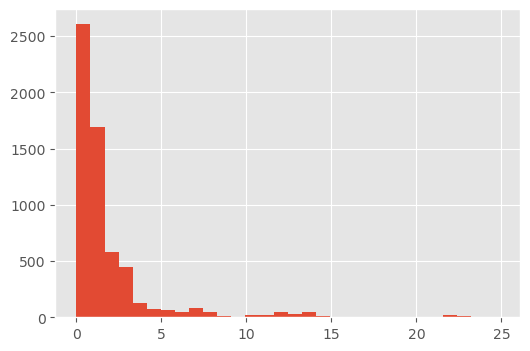

In [174]:
data['min_dist_to_subway'].hist(bins=30);

In [175]:
centre_loc = (50.450555, 30.5206892) # geo of Kyiv centre
centre_loc

(50.450555, 30.5206892)

In [177]:
def get_dist_to_center(x):
    if x:
        adr_loc = (x.latitude, x.longitude)
        dist = geodesic(adr_loc, centre_loc).kilometers
        return dist
    else:
        return None

In [178]:
data['dist_to_center'] = data['location'].progress_apply(get_dist_to_center)
data['dist_to_center']

100%|██████████| 6938/6938 [00:01<00:00, 3779.41it/s]


0        4.923706
1        1.193693
2       13.865792
3        5.058597
4        7.171231
          ...    
6933    10.513925
6934    10.100934
6935     8.437642
6936    49.363906
6937     9.018328
Name: dist_to_center, Length: 6938, dtype: float64

<Axes: >

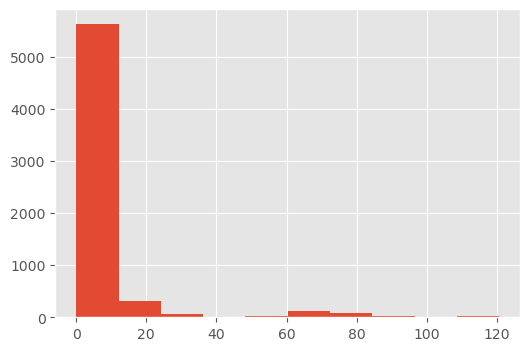

In [179]:
data['dist_to_center'].hist()

In [180]:
data['dist_to_center'] = data['dist_to_center'].apply(lambda x: x if x <= 40 else None)

<Axes: >

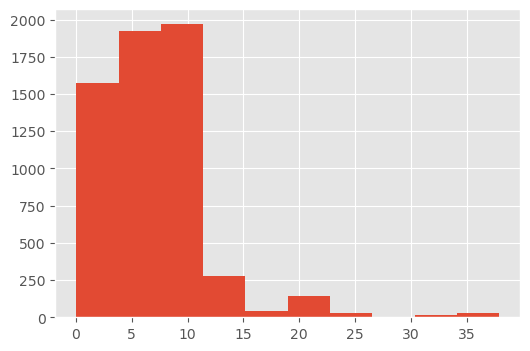

In [182]:
data['dist_to_center'].hist()

In [184]:
data.to_csv('real_estate_geo.csv', index=False)

In [24]:
# get X_train, X_test, y_train, y_test from data
def get_train_test(df, feats, log=False):
    X = df[feats]
    if log:
        y = np.log1p(df['price'])
    else:
        y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test

In [195]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X_train, y_train, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3766, test_rmsle: 0.3821
[Fold 1] train_rmsle: 0.3774, test_rmsle: 0.3881
[Fold 2] train_rmsle: 0.3798, test_rmsle: 0.3971
[Fold 3] train_rmsle: 0.3745, test_rmsle: 0.3854
[Fold 4] train_rmsle: 0.3731, test_rmsle: 0.3934
RMSLE: 0.3892 ± 0.0054


previous result: 0.4270 ± 0.0142

In [196]:
run_cv(model, X_train, y_train, folds=5, target_log=True, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3237, test_rmsle: 0.3180
[Fold 1] train_rmsle: 0.3218, test_rmsle: 0.3286
[Fold 2] train_rmsle: 0.3193, test_rmsle: 0.3358
[Fold 3] train_rmsle: 0.3196, test_rmsle: 0.3355
[Fold 4] train_rmsle: 0.3176, test_rmsle: 0.3434
RMSLE: 0.3322 ± 0.0085


previous result: 0.3786 ± 0.0105

In [39]:
data = pd.read_csv('../data/real_estate_geo.csv')

In [40]:
data


,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
0,10825753,133000,4,14,"Драгомирова вул., 11",Печерський р-н,дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",...,1,0,1,1,0,"11, вулиця Михайла Драгомирова, Новопечерські ...",50.409315,30.545859,0.895612,4.923706
1,10784117,22762,3,6,Шовковична вул.,Печерський р-н,хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,...,1,0,0,1,1,"Шовковична вулиця, Левашовська Гора, Графська ...",50.440876,30.527947,0.520707,1.193693
2,10810186,8499,1,19,Доковська вул.,Святошинський р-н,академмістечко,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,...,0,0,0,0,0,"Гапонів доківська, Залізнична вулиця, Коцюбинс...",50.488823,30.334814,2.980520,13.865792
3,10824293,10500,1,18,Каховська вул.,Дніпровський р-н,лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,...,0,0,0,0,0,"Каховська вулиця, Микільська Слобідка, Дніпров...",50.468776,30.585959,2.076273,5.058597
4,10819688,37962,2,18,"Оболонський просп., 26",Оболонський р-н,мінська,ПРЕМІУМ,ЖК Obolon Residences,"ВИДЕО-ТУР\n\nНОВАЯ 2-к квартира, ЖК Obolon Res...",...,1,0,1,0,0,"СУШИ-МАСТЕР, 26, Оболонський проспект, Оболонь...",50.513615,30.499695,0.521587,7.171231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933,10620878,16000,1,9,"Крамського Івана вул., 9",Святошинський р-н,житомирська,Доступна на короткий термін,"ЖК Будинок на вул. Крамського, 9","м. Київ, вул. Крамського 9. Оренда 1но кім. ...",...,1,0,0,1,1,"Бутік Отік, 9, вулиця Івана Крамського, Скарбо...",50.453460,30.372720,0.593687,10.513925
6934,10803998,9500,1,8,"Кіпріанова академіка вул., 6А",Святошинський р-н,святошин,NaN,Микільська Борщагівка,Здам 1-кімнатну квартиру по вул. Академіка Кіп...,...,1,0,0,1,0,"6-А, Академіка Кіпріанова вулиця, Микільська Б...",50.438831,30.379677,2.167840,10.100934
6935,9615917,6000,2,3,"Данила Щербаківського вул. (Щербакова), 54",Шевченківський р-н,святошин,Святошин,Нивки,На длительную аренду по ул Львовская в отличн...,...,1,0,0,0,0,"Ощадбанк, 54, вулиця Данила Щербаківського, Ни...",50.471670,30.406559,1.475453,8.437642
6936,10055853,9000,1,3,"Стуса Василя вул., 28а",Святошинський р-н,NaN,NaN,NaN,"Просторная квартира, большая кухня, два балкон...",...,1,0,1,1,0,"Василя Стуса вулиця, Макарів, Макарівська сели...",50.472214,29.826320,NaN,NaN


In [41]:
data.rooms.unique()

array(['4', '3', '1', '2', '5', 'Вільне', '6'], dtype=object)

In [42]:
data[data['rooms'] == 'Вільне'][['full_area', 'living_area']]

,full_area,living_area
470,120.0,95.0
4062,50.0,40.0
4754,48.1,18.5
6732,30.0,15.0


In [56]:
data[data['free_planning'] == 1]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
1311,10803242,38000,3,7,"Коломийський пров., 17/31",Голосіївський р-н,васильківська,Васильківська,ЖК Васильківський,Довгострокова оренда 3-х кімнатної квартири з ...,...,1,0,0,0,1,"ЛотОК, 17/31а, Коломийський провулок, Голосіїв...",50.393471,30.49080,0.422412,6.695681
6905,10810065,20000,3,14,"Драгомирова вул., 19б",Печерський р-н,NaN,NaN,ЖК Новопечерські Липки,Аренда 3-х квартири в ЖК Печерські Липки піс...,...,0,0,0,0,0,"Чічіко, 19-Б, вулиця Михайла Драгомирова, Ново...",50.407066,30.54399,1.140601,5.113108


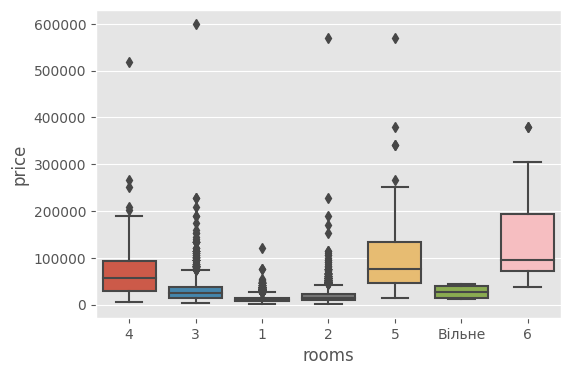

In [50]:
sns.boxplot(x='rooms', y='price', data=data);

In [51]:
data.loc[data['rooms'] == 'Вільне', 'rooms'] = 1

In [57]:
data.loc[data['rooms'] == 1, 'free_planning'] = 1

In [58]:
data[data['free_planning'] == 1]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
470,10398243,45000,0,2,"Велика Васильківська вул. (Червоноармійська), 47",Печерський р-н,олімпійська,Доступна на короткий термін,Черепанова гора,"Будинок - стара цегла, квартира вільного плану...",...,1,1,0,0,0,"47, Велика Васильківська вулиця, Бессарабка, К...",50.434999,30.516471,0.403354,1.756135
1311,10803242,38000,3,7,"Коломийський пров., 17/31",Голосіївський р-н,васильківська,Васильківська,ЖК Васильківський,Довгострокова оренда 3-х кімнатної квартири з ...,...,1,0,0,0,1,"ЛотОК, 17/31а, Коломийський провулок, Голосіїв...",50.393471,30.490800,0.422412,6.695681
4062,10819168,16500,0,19,"Євгена Сверстюка вул. (Раскової Марини), 6Б",Дніпровський р-н,лівобережна,Лівобережна,ЖК Галактика,Здається світла і простора кваритра у жк «Гала...,...,1,0,1,1,1,"Трансформаторна підстанція, 6-Б, вулиця Євгена...",50.445806,30.604496,0.819574,5.975943
4754,10764600,38000,0,4,Дегтярна вул.,Подільський р-н,контрактова площа,Контрактова площа,ЖК Подол Град,"Мінімалістична, світла, функціонально наповнен...",...,0,0,0,0,0,"Дегтярна вулиця, Гончарі-Кожум’яки, Поділ, Под...",50.458195,30.510575,0.832266,1.112755
6732,9836715,11500,0,4,"Каховська вул., 60",Дніпровський р-н,лівобережна,Лівобережна,NaN,Идеально для одного или пары\nЕсть все для ком...,...,0,0,0,0,0,"COFFEE-PORT, 60, Каховська вулиця, Хутір, Ліво...",50.463101,30.591329,1.338820,5.206919
6905,10810065,20000,3,14,"Драгомирова вул., 19б",Печерський р-н,NaN,NaN,ЖК Новопечерські Липки,Аренда 3-х квартири в ЖК Печерські Липки піс...,...,0,0,0,0,0,"Чічіко, 19-Б, вулиця Михайла Драгомирова, Ново...",50.407066,30.543990,1.140601,5.113108


In [52]:
data.rooms.unique()

array(['4', '3', '1', '2', '5', 0, '6'], dtype=object)

In [53]:
data.rooms = data.rooms.astype('int8')

In [54]:
data.rooms.dtypes

dtype('int8')

In [60]:
data.to_csv('real_estate_geo_2.csv', index=False)

In [59]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X_train, y_train, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3755, test_rmsle: 0.3789
[Fold 1] train_rmsle: 0.3823, test_rmsle: 0.3967
[Fold 2] train_rmsle: 0.3749, test_rmsle: 0.3938
[Fold 3] train_rmsle: 0.3745, test_rmsle: 0.3923
[Fold 4] train_rmsle: 0.3704, test_rmsle: 0.3921
RMSLE: 0.3908 ± 0.0062


[Fold 0] train_rmsle: 0.3766, test_rmsle: 0.3821
[Fold 1] train_rmsle: 0.3774, test_rmsle: 0.3881
[Fold 2] train_rmsle: 0.3798, test_rmsle: 0.3971
[Fold 3] train_rmsle: 0.3745, test_rmsle: 0.3854
[Fold 4] train_rmsle: 0.3731, test_rmsle: 0.3934
RMSLE: 0.3892 ± 0.0054

### StratifiedKFold by rooms

In [7]:
data = pd.read_csv('../data/real_estate_geo_2.csv')

In [8]:
data.shape

(6938, 67)

In [10]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6938 non-null   int64  
 1   price                   6938 non-null   int64  
 2   rooms                   6938 non-null   int64  
 3   floor                   6938 non-null   int64  
 4   adress                  6938 non-null   object 
 5   district                6938 non-null   object 
 6   subway                  5464 non-null   object 
 7   class                   5155 non-null   object 
 8   residential             6483 non-null   object 
 9   description             6938 non-null   object 
 10  detail                  6938 non-null   object 
 11  full_area               6938 non-null   float64
 12  living_area             6938 non-null   float64
 13  kitchen_area            6938 non-null   float64
 14  num_storeys             6938 non-null   

In [12]:
for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=24).split(data, data['rooms']):
    print(train_idx, test_idx)

[   0    1    3 ... 6935 6936 6937] [   2    4   11 ... 6918 6932 6933]
[   0    1    2 ... 6935 6936 6937] [   7    9   13 ... 6927 6928 6929]
[   0    1    2 ... 6935 6936 6937] [  16   20   23 ... 6902 6921 6926]
[   2    4    5 ... 6933 6934 6936] [   0    1    3 ... 6925 6935 6937]
[   0    1    2 ... 6933 6935 6937] [   5    6    8 ... 6931 6934 6936]


d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [14]:
data[data['free_planning'] == 1]['rooms']

470     0
1311    3
4062    0
4754    0
6732    0
6905    3
Name: rooms, dtype: int64

In [17]:
data[data['rooms'] == 0]['full_area']

470     120.0
4062     50.0
4754     48.1
6732     30.0
Name: full_area, dtype: float64

In [21]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

In [22]:
data['rooms'].value_counts()

rooms
2    2717
1    2341
3    1412
4     346
5      96
6      26
Name: count, dtype: int64

In [23]:
data.to_csv('../data/real_estate_geo_2.csv', index=False)

### `location` and `district`

In [67]:
data = pd.read_csv('../data/real_estate_geo_3.csv')

In [68]:
data['district'].value_counts(dropna=False)

district
Печерський р-н        1270
Дарницький р-н        1026
Шевченківський р-н     982
Голосіївський р-н      801
Дніпровський р-н       715
Солом'янський р-н      589
Оболонський р-н        466
Святошинський р-н      407
Деснянський р-н        349
Подільський р-н        333
Name: count, dtype: int64

In [69]:
data['district'] = data['district'].apply(lambda x: x.split(' ')[0])

In [40]:
data['district'].value_counts(dropna=False)

district
Печерський        1270
Дарницький        1026
Шевченківський     982
Голосіївський      801
Дніпровський       715
Солом'янський      589
Оболонський        466
Святошинський      407
Деснянський        349
Подільський        333
Name: count, dtype: int64

In [32]:
geolocator = Nominatim(user_agent="my_request")

def get_location(address):
    loc = address + ', Київ'
    location = geolocator.geocode(loc)
    if location:
        lat = location.latitude
        lon = location.longitude
    else:
        lat = None
        lon = None
    return (lat, lon)

In [33]:
loc = 'Святошинський, Київ'
get_location(loc)

(50.459437050000005, 30.331931174544472)

In [34]:
districts = ['Печерський', 'Дарницький', 'Шевченківський', 'Голосіївський',
             'Дніпровський', 'Солом\'янський', 'Оболонський', 'Святошинський',
             'Деснянський', 'Подільський']

In [35]:
district_location = {}
for district in tqdm(districts):
    loc = district + ', Київ'
    location = geolocator.geocode(loc)
    if location:
        district_lat = location.latitude
        district_lon = location.longitude
    else:
        district_lat = None
        district_lon = None
    district_location[district] = {'district_lat': district_lat, 'district_lon': district_lon}
    sleep(0.5)

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


In [41]:
df_district_location = pd.DataFrame(district_location).T
df_district_location.reset_index(inplace=True)
df_district_location.rename(columns={'index': 'district'}, inplace=True)
df_district_location

,district,district_lat,district_lon
0,Печерський,50.445827,30.538062
1,Дарницький,50.429108,30.642467
2,Шевченківський,50.358344,30.957756
3,Голосіївський,50.384401,30.487054
4,Дніпровський,50.451827,30.611397
5,Солом'янський,50.439856,30.488655
6,Оболонський,50.507920,30.520662
7,Святошинський,50.459437,30.331931
8,Деснянський,50.475283,30.681692
9,Подільський,50.475000,30.512650


In [ ]:
df_district_location.loc[2, 'district_lat'] = 50.467421
df_district_location.loc[2, 'district_lon'] = 30.463848

In [60]:
df_district_location.to_csv('../data/district_location.csv', index=False)

In [70]:
data = data.merge(df_district_location, how='left', on='district')

In [71]:
data[['district_lat', 'district_lon']]

,district_lat,district_lon
0,50.445827,30.538062
1,50.445827,30.538062
2,50.459437,30.331931
3,50.451827,30.611397
4,50.507920,30.520662
...,...,...
6933,50.459437,30.331931
6934,50.459437,30.331931
6935,50.358344,30.957756
6936,50.459437,30.331931


In [72]:
data['lat'].fillna(data['district_lat'], inplace=True)
data['lon'].fillna(data['district_lon'], inplace=True)


In [73]:
data['lat'].isna().sum(), data['lon'].isna().sum()

(0, 0)

In [74]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [75]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y


def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)


def calc_train_error(X_train, y_train, model, metric, target_log):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_train = np.exp(y_train)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_train, y_pred][:5])
    return metric(y_train, y_pred)


def calc_validation_error(X_test, y_test, model, metric, target_log):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    if target_log:
        y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_test, y_pred][:5])
    return metric(y_test, y_pred)


def calc_metrics(X_train, y_train, X_test, y_test, model, metric, target_log):
    '''fits model and returns the RMSLE for in-sample error and out-of-sample error'''
    if target_log:
       y_train = np.log(y_train)
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model, metric, target_log)
    validation_error = calc_validation_error(X_test, y_test, model, metric, target_log)
    return train_error, validation_error

In [49]:

def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    train_scores = []
    test_scores = []
    k = 0
    for train_idx, test_idx in cv.split(X, X['rooms']):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
       
        train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test, model, success_metric, target_log)
        print(f"[Fold {k}] train_rmsle: {train_score:.4f}, test_rmsle: {test_score:.4f}")
        train_scores.append(train_score)
        test_scores.append(test_score)
        k += 1
        
    print(f"RMSLE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    return

In [76]:
X, y = get_X_y(data, num_feats)
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X, y, folds=5, target_log=False, cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3755, test_rmsle: 0.3957
[Fold 1] train_rmsle: 0.3659, test_rmsle: 0.3860
[Fold 2] train_rmsle: 0.3780, test_rmsle: 0.3696
[Fold 3] train_rmsle: 0.3745, test_rmsle: 0.3620
[Fold 4] train_rmsle: 0.3651, test_rmsle: 0.3930
RMSLE: 0.3813 ± 0.0132


In [77]:
black_list = ['id', 'price', 'class', 'residential', 'detail',
              'description', 'subway_old', 'district_lat', 'district_lon']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [78]:
X, y = get_X_y(data, num_feats)
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X, y, folds=5, target_log=False, cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3759, test_rmsle: 0.4010
[Fold 1] train_rmsle: 0.3716, test_rmsle: 0.3880
[Fold 2] train_rmsle: 0.3838, test_rmsle: 0.3790
[Fold 3] train_rmsle: 0.3738, test_rmsle: 0.3641
[Fold 4] train_rmsle: 0.3696, test_rmsle: 0.3949
RMSLE: 0.3854 ± 0.0129


In [ ]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]